# Model Predictive Analysis

In this notebook we use the final best model obtained from the modelling notebook to see what we can do with it using the test data.

Imagine a chess player came to you with some stats of his chess games. Say he only has 10-20 chess games under his belt, which may not be enough data to come to any conclusions regarding his chess playing abilities, but he still has some questions about how he is playing. You can then use the final XGBoost model to predict who should've won in his games, to then help answer some questions. 

Some of these questions could be:
 - Do I play differently when games are rated or not, i.e. do I have a greater tendency to win or lose when games are rated?
 - When games are won by resignation, is it because my opponent just gave up or did I?
 - Do I have a tendency to win or lose when playing as white or black?
 - Do I have a tendency to win or lose with certain opening moves? Regardless of actual victory or not, if the model predicts more victories given a certain opening move, then this might indicate the player is making better move choices after this opening.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score, accuracy_score

#some copy warning we don't care about at the moment
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_pickle('train_df.pkl')
test = pd.read_pickle('test_df.pkl')

EDA_df = pd.read_pickle('EDA_df.pkl')

In [3]:
unproc_test = EDA_df.iloc[test.index]

We need to make a function that can get the indices of a certain player from a test dataset, so that we can access the original data from the EDA_df so we can see what the unprocessed data looks like for analysis. We can also take value counts to see what players had the most games, as playing either white or black.

In [4]:
def player_index(player_id, df):
    #getting the indices of all games of a certain player in the test set
    player_test_indices = list(df[df['black_id'] == player_id].index) + list(df[df['white_id'] == player_id].index)
    
    return player_test_indices

In [5]:
unproc_test['black_id'].value_counts()

s-a             12
mrmandelbrot    11
zen3000         11
andreas00       11
sjeiben         11
                ..
pedronev         1
mimelam          1
sanpenko         1
digvijay         1
sergiofil6       1
Name: black_id, Length: 3119, dtype: int64

In [6]:
unproc_test['white_id'].value_counts()

ranchowangdu          13
vovkakuz              13
khelil                13
ssf7                  12
hassan1365416         11
                      ..
liotru                 1
mmmaks61-dikiyvest     1
petrovich32            1
drillinger             1
dmitrykol              1
Name: white_id, Length: 3095, dtype: int64

Now let's get our model and make predictions just on our players.

In [7]:
y = train['winner_label']
X = train.drop(columns = 'winner_label')

y_test = test['winner_label']
X_test = test.drop(columns = 'winner_label')

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3, 
                          random_state=42, 
                          n_jobs=-1, 
                          tree_method='gpu_hist',
                          max_depth=5, 
                          learning_rate=0.4, 
                          n_estimators=150, 
                          min_child_weight=7)

xgb_clf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

Next is the function that will just take player id name and output a dataframe with that players games from the testing set, along with the predicted winner of each of their games.

In [8]:
def get_player_df(player_id):
    #get the indices of the player
    player_indices = player_index(player_id, unproc_test)
    #make an unprocessed df with the player_indices
    player_df = EDA_df.iloc[player_indices]
    
    y_pred = xgb_clf.predict(X_test.loc[player_indices])
    
    #convert number labels to actual string labels
    winner_labels = {0: 'black', 1: 'draw', 2: 'white'}
    [winner_labels[w] for w in y_pred]
    
    #add the predicted labels to the df
    player_df['predicted_winner'] = [winner_labels[w] for w in y_pred]
    
    #reorganize the winner label to be at the end next to the predicted winner column
    player_df = player_df[[c for c in player_df.columns if c != 'winner'] + ['winner']]
    
    return player_df

## Analysis

Now we can explore the results given a certain player.

### Analyzing zen3000

In [9]:
zen3000_df = get_player_df('zen3000')

In [10]:
print('Number of rated games:', sum(zen3000_df['rated'] == True))

Number of rated games: 0


So this player didn't have any rated games here, so there is nothing to explore here.

In [11]:
#this function gives the number of times a player won given some condition on any other feature
#you can choose to see either the predicted wins or the players actual wins
def conditional_wins(player_id, conditional_col, conditional_val, pred_or_actual_winner_col):
    #number of victories counter variable
    wins = 0
    
    #get the players df
    player_df = get_player_df(player_id)
    
    #filter the players df for the column of interest and the condition
    cond_df = player_df[player_df[conditional_col] == conditional_val]
    
    #iterate through the df and add one to wins if the player won as either black or white
    #pred_or_actual_winner_col takes in either the 'winner' column or the 'predicted_winner' column
    for rows, cols in cond_df.iterrows():
        if cond_df.loc[rows]['black_id'] == player_id and cond_df.loc[rows][pred_or_actual_winner_col] == 'black':
            wins += 1
        elif cond_df.loc[rows]['white_id'] == player_id and cond_df.loc[rows][pred_or_actual_winner_col] == 'white':
            wins += 1
    
    #also return the number of games the player had with the given condition
    num_of_cond = cond_df.shape[0]
    
    return wins, num_of_cond

In [12]:
print(conditional_wins('zen3000', 'victory_status', 'resign', 'predicted_winner'))
print(conditional_wins('zen3000', 'victory_status', 'resign', 'winner'))

(7, 10)
(5, 10)


In [13]:
print(conditional_wins('zen3000', 'black_id', 'zen3000', 'predicted_winner'))
print(conditional_wins('zen3000', 'black_id', 'zen3000', 'winner'))

(9, 11)
(9, 11)


In [14]:
print(conditional_wins('zen3000', 'white_id', 'zen3000', 'predicted_winner'))
print(conditional_wins('zen3000', 'white_id', 'zen3000', 'winner'))

(3, 5)
(1, 5)


In [15]:
zen3000_df['opening_name'].value_counts()

Slav Defense: Three Knights Variation                                1
Ruy Lopez: Exchange Variation                                        1
Russian Game: Three Knights Game                                     1
Four Knights Game: Scotch Variation                                  1
Italian Game: Giuoco Pianissimo |  Italian Four Knights Variation    1
Ruy Lopez: Morphy Defense |  Caro Variation                          1
King's Pawn Game: Napoleon Attack                                    1
Van't Kruijs Opening                                                 1
King's Pawn Game: Wayward Queen Attack                               1
King's Knight Opening: Normal Variation                              1
Slav Defense: Modern                                                 1
French Defense: Advance Variation |  Euwe Variation                  1
Italian Game                                                         1
Giuoco Piano                                                         1
Petrov

All opening names used here by this player are unique, so nothing to explore here. Now we can visualize the other three conditions.

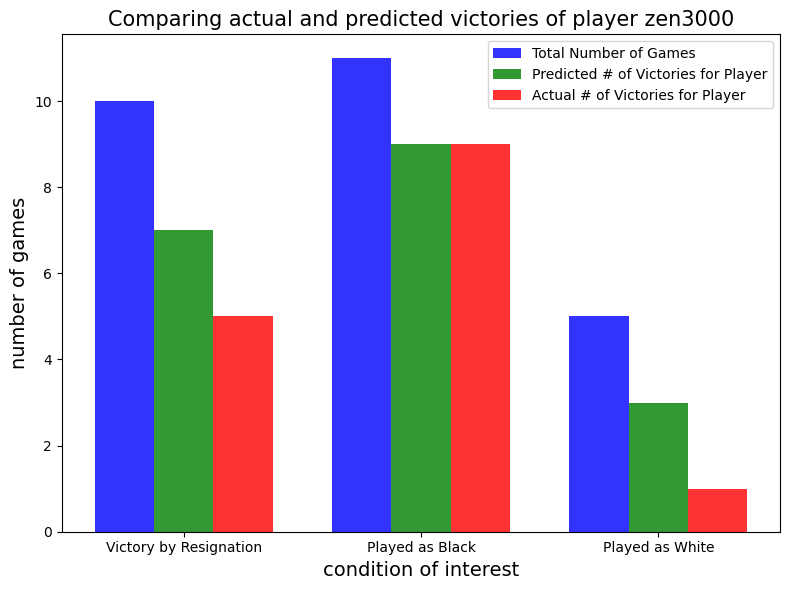

In [16]:
# data to plot
zen_pred_resign = conditional_wins('zen3000', 'victory_status', 'resign', 'predicted_winner')
zen_actual_resign = conditional_wins('zen3000', 'victory_status', 'resign', 'winner')

zen_pred_black = conditional_wins('zen3000', 'black_id', 'zen3000', 'predicted_winner')
zen_actual_black = conditional_wins('zen3000', 'black_id', 'zen3000', 'winner')

zen_pred_white = conditional_wins('zen3000', 'white_id', 'zen3000', 'predicted_winner')
zen_actual_white = conditional_wins('zen3000', 'white_id', 'zen3000', 'winner')

total_games = [zen_pred_resign[1], zen_pred_black[1], zen_pred_white[1]]
pred_values = [zen_pred_resign[0], zen_pred_black[0], zen_pred_white[0]]
actual_values = [zen_actual_resign[0], zen_actual_black[0], zen_actual_white[0]]

# create plot
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, total_games, bar_width,
alpha=opacity,
color='b',
label='Total Number of Games')

rects2 = plt.bar(index + bar_width, pred_values, bar_width,
alpha=opacity,
color='g',
label='Predicted # of Victories for Player')

rects3 = plt.bar(index + 2*bar_width, actual_values, bar_width,
alpha=opacity,
color='r',
label='Actual # of Victories for Player')

plt.xlabel('condition of interest', fontsize=14)
plt.ylabel('number of games', fontsize=14)
plt.title('Comparing actual and predicted victories of player {}'.format('zen3000'), fontsize=15)
plt.xticks(index + bar_width, ('Victory by Resignation', 'Played as Black', 'Played as White'))
plt.legend()

plt.tight_layout()
plt.savefig('figures/comparison_plot_zen3000.jpg', bbox_inches = "tight")
plt.show()

So the model is more favourable towards zen3000 when predicting his/her victory for game that end in resignation. This could indicate that the player is better at winning via resignation then what his original stats might suggest.

The model and how many times the player actually won when playing as black are in agreement, so it seems like the player is likely to win when playing as black. When playing as white, the player might think he is not likely to win based on his own stats, but the might suggests otherwise, and that he still has a decent chance at winning. In any case, the player can probably conclude that playing as black is a good idea for him.

In [17]:
# a function to get a players df where only the player won
def player_wins_df(player_id, winner_col):
    player_df = get_player_df(player_id)
    
    wins_df = player_df[((player_df[winner_col] == 'black') & (player_df['black_id'] == player_id)) | 
                        ((player_df[winner_col] == 'white') & (player_df['white_id'] == player_id))]
    return wins_df

# a function to get a players df where only the player lost
def player_losses_df(player_id, winner_col):
    player_df = get_player_df(player_id)
    
    losses_df = player_df[((player_df[winner_col] == 'black') & (player_df['black_id'] != player_id)) | 
                        ((player_df[winner_col] == 'white') & (player_df['white_id'] != player_id))]
    return losses_df

In [18]:
zen3000_pred_wins = player_wins_df('zen3000', 'predicted_winner')

In [19]:
#we get get a closer look and see if there are any patterns for games won by resignation
zen3000_pred_wins[zen3000_pred_wins['victory_status'] == 'resign']

,id,rated,turns,victory_status,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,time_allotted,increment,predicted_winner,winner
18543,gvrbnQkc,False,56,resign,franky74,1500,zen3000,1500,e4 e5 Nf3 Nc6 Bb5 a6 Bxc6 dxc6 Nxe5 Qd4 Nf3 Qx...,C68,Ruy Lopez: Exchange Variation,7,10,0,black,black
18509,uFkgAGQs,False,60,resign,kiroram,1316,zen3000,1500,e4 e5 Nc3 Nf6 Nf3 d5 h3 d4 Ne2 Bc5 d3 Nc6 a3 B...,C42,Russian Game: Three Knights Game,5,10,0,black,black
18533,rhPXfhr1,False,59,resign,songoficeandvodka,1294,zen3000,1500,e4 e5 Nf3 Nc6 Nc3 Nf6 d4 Bb4 Bd2 O-O d5 Nd4 Nx...,C47,Four Knights Game: Scotch Variation,7,10,0,black,black
18512,OayTMTSX,False,68,resign,shannonhartman77,1095,zen3000,1500,e4 e5 Nf3 Nc6 Bc4 Nf6 Nc3 Bc5 d3 h6 a3 a6 O-O ...,C50,Italian Game: Giuoco Pianissimo | Italian Fou...,9,10,0,black,white
18510,mVrzHE7Q,False,44,resign,wutang22,1306,zen3000,1500,Nf3 Nf6 d4 d5 c4 c6 cxd5 Qa5+ Bd2 Qxd5 Nc3 Qd8...,D11,Slav Defense: Modern,6,8,0,black,black
18550,vjUH0WGA,False,98,resign,zen3000,1500,merefelle,1500,e4 e6 d4 d5 e5 c5 c3 Nc6 Nf3 Bd7 Bb5 Nxe5 Bxd7...,C02,French Defense: Advance Variation | Euwe Vari...,10,10,0,white,black
18508,v0c1ku0T,False,42,resign,zen3000,1500,angelpov,1500,e4 e5 Nf3 Nc6 Bc4 d6 d4 exd4 Nxd4 Nxd4 Qxd4 h6...,C50,Italian Game,5,10,0,white,black


It doesn't seem like there are any significant patterns here.

We can check value counts for certain features.

In [20]:
zen3000_pred_wins['time_allotted'].value_counts()

10    11
8      1
Name: time_allotted, dtype: int64

Most games were allotted 10 minutes when the player won. Let's check losses.

In [21]:
player_losses_df('zen3000', 'predicted_winner')

,id,rated,turns,victory_status,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,time_allotted,increment,predicted_winner,winner
18531,Lbr9NTOR,False,13,resign,silentsheep,1500,zen3000,1500,d4 d5 c4 c6 Nc3 Nf6 Nf3 Bg4 Bg5 Nbd7 e3 e6 Ne5,D15,Slav Defense: Three Knights Variation,7,10,0,white,black
18507,iQcJqNpa,False,65,resign,trymctryhard,1500,zen3000,1500,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 Nf6 d3 a5 a4 b...,C70,Ruy Lopez: Morphy Defense | Caro Variation,8,10,0,white,white
18513,9QRCqtCl,False,14,resign,zen3000,1500,aljon1,1386,e4 e5 Nf3 Nf6 Nxe5 Qe7 d4 d6 Nf3 Nxe4 Bc4 Nc3+...,C42,Petrov's Defense #2,5,10,0,black,black


No significant patterns here either. All games that zen3000 played were allotted 10 minutes, so this isn't significant, even though you might think so given just the wins df.


### Analyzing totonut

We can investigate another player now. After some trial and error of looking at interesting players, totonut will be the next player to analyze.

In [22]:
totonut_df = get_player_df('totonut')

In [23]:
print(conditional_wins('totonut', 'rated', True, 'predicted_winner'))
print(conditional_wins('totonut', 'rated', True, 'winner'))

(3, 10)
(4, 10)


In [24]:
print(conditional_wins('totonut', 'rated', False, 'predicted_winner'))
print(conditional_wins('totonut', 'rated', False, 'winner'))

(4, 7)
(5, 7)


So based on both predicted and actual wins, totonut is more likely to lose rated games, and the opposite for non-rated games.

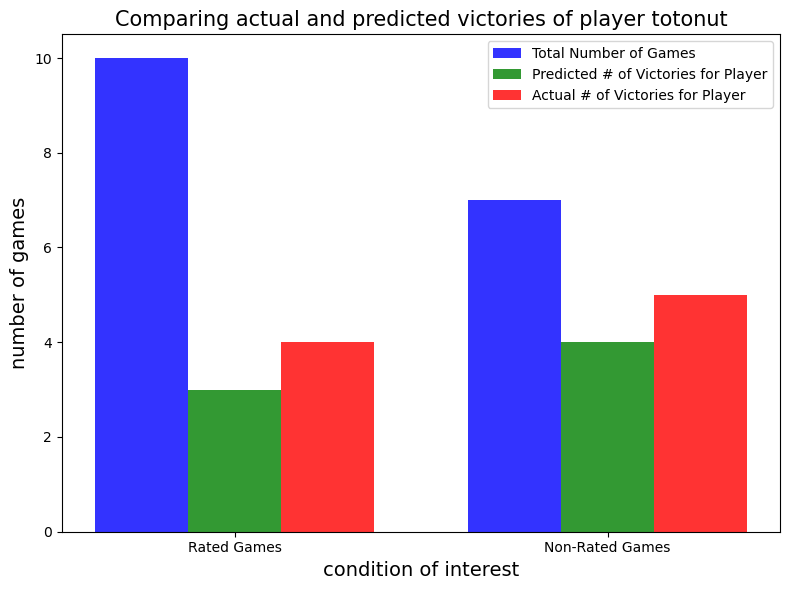

In [25]:
# data to plot
totonut_pred_rated_wins = conditional_wins('totonut', 'rated', True, 'predicted_winner')
totonut_actual_rated_wins = conditional_wins('totonut', 'rated', True, 'winner')

totonut_pred_non_rated = conditional_wins('totonut', 'rated', False, 'predicted_winner')
totonut_actual_non_rated = conditional_wins('totonut', 'rated', False, 'winner')

total_games = [totonut_pred_rated_wins[1], totonut_pred_non_rated[1]]
pred_values = [totonut_pred_rated_wins[0], totonut_pred_non_rated[0]]
actual_values = [totonut_actual_rated_wins[0], totonut_actual_non_rated[0]]

# create plot
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, total_games, bar_width,
alpha=opacity,
color='b',
label='Total Number of Games')

rects2 = plt.bar(index + bar_width, pred_values, bar_width,
alpha=opacity,
color='g',
label='Predicted # of Victories for Player')

rects3 = plt.bar(index + 2*bar_width, actual_values, bar_width,
alpha=opacity,
color='r',
label='Actual # of Victories for Player')

plt.xlabel('condition of interest', fontsize=14)
plt.ylabel('number of games', fontsize=14)
plt.title('Comparing actual and predicted victories of player {}'.format('totonut'), fontsize=15)
plt.xticks(index + bar_width, ('Rated Games', 'Non-Rated Games'))
plt.legend()

plt.tight_layout()
plt.savefig('figures/totonut_comparison_plot.jpg', bbox_inches = "tight")
plt.show()

Now lets look more closely at these four possibilities, of whether totonut wins or loses a rated or non-rated game.

In [26]:
totonut_losses_df = player_losses_df('totonut', 'predicted_winner')
totonut_wins_df = player_wins_df('totonut', 'predicted_winner')

In [27]:
#make a helper function to plot mor bar plots
def value_count_of_player(player_id, df, feature, value, feature2):
    feature_value_df = df[df[feature] == value]
    
    vc = feature_value_df[feature2].value_counts()
    return vc

The most useful thing to look at would be rated games where totonut lost, but we can look at all plots here.

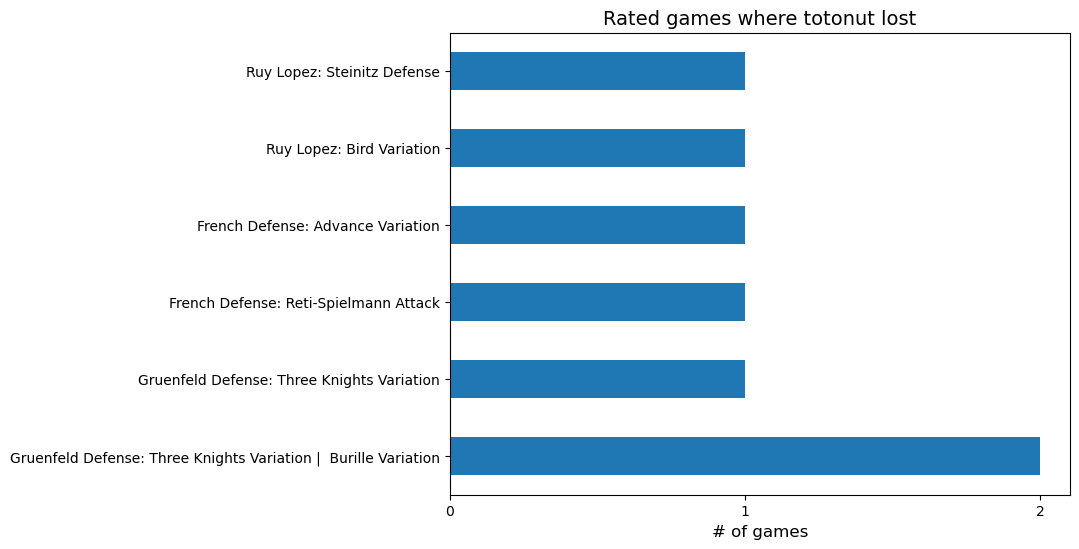

In [28]:
value_count_of_player('totonut', totonut_losses_df, 'rated', True, 'opening_name').plot.barh(xticks=[0, 1, 2])

plt.xlabel('# of games', fontsize=12)
plt.title('Rated games where totonut lost', fontsize=14)
plt.savefig('figures/rated_lost_totonut.jpg', bbox_inches = "tight")
plt.show()

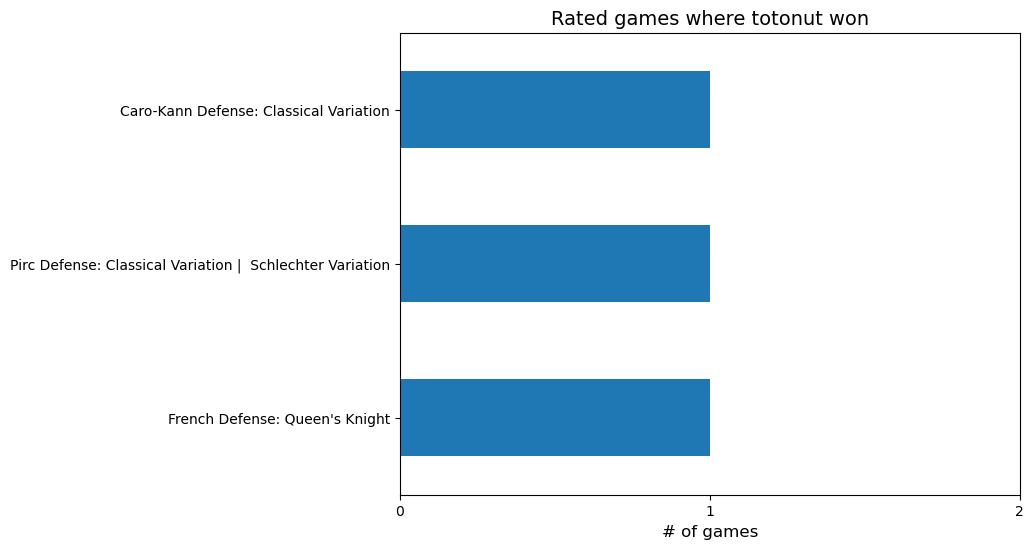

In [29]:
value_count_of_player('totonut', totonut_wins_df, 'rated', True, 'opening_name').plot.barh(xticks=[0, 1, 2])

plt.xlabel('# of games', fontsize=12)
plt.title('Rated games where totonut won', fontsize=14)
plt.savefig('figures/rated_wins_totonut.jpg', bbox_inches = "tight")
plt.show()

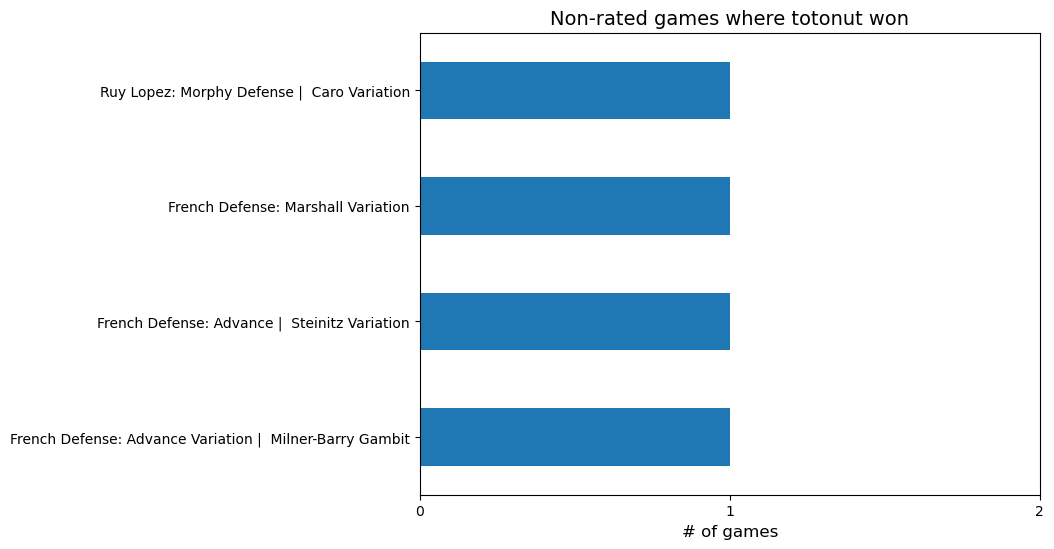

In [30]:
value_count_of_player('totonut', totonut_wins_df, 'rated', False, 'opening_name').plot.barh(xticks=[0, 1, 2])

plt.xlabel('# of games', fontsize=12)
plt.title('Non-rated games where totonut won', fontsize=14)
plt.savefig('figures/nonrated_wins_totonut.jpg', bbox_inches = "tight")
plt.show()

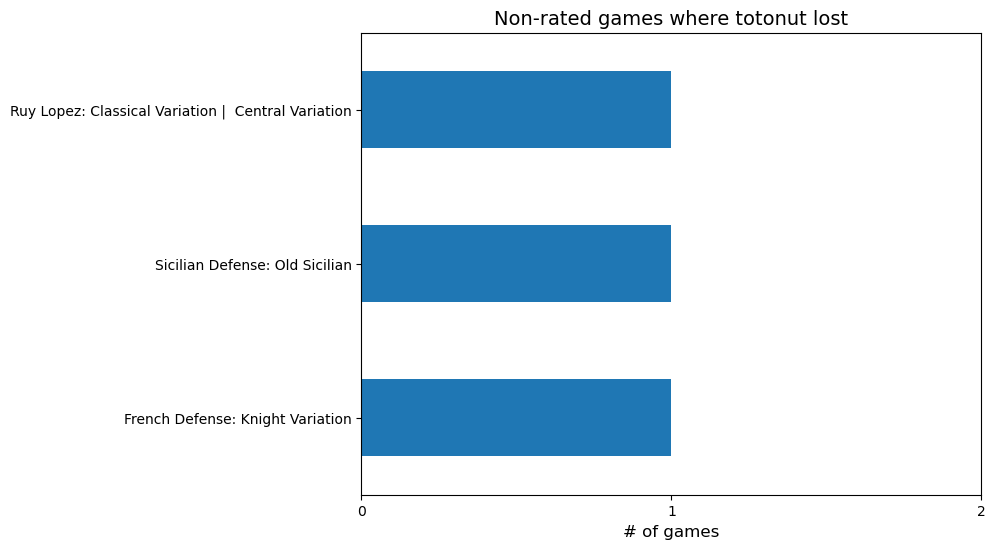

In [31]:
value_count_of_player('totonut', totonut_losses_df, 'rated', False, 'opening_name').plot.barh(xticks=[0, 1, 2])

plt.xlabel('# of games', fontsize=12)
plt.title('Non-rated games where totonut lost', fontsize=14)
plt.savefig('figures/nonrated_lost_totonut.jpg', bbox_inches = "tight")
plt.show()